### MATH2504 S2, 2024, BigHW Submission 
### Submission form IV of IV 

Student #1 name: Yingjie Gu

Student #1 ID: 47982558

Student #2 name: Zhihan Niu

Student #2 ID: 48154857

GitHub repo: https://github.com/Superjelly-ux/Yingjie-Gu__Zhihan-Niu-2504-2025-BigHW

---

**Note: It is expected that this notebook be runnable in the sense that the marker can select "Restart & Run All" and all code cells of solutions will execute. This requires not to have name clashes between solutions.**

---

# Solution to [Question 13](https://courses.smp.uq.edu.au/MATH2504/2024/assessment_html/bighw.html#q13)

## 13a:

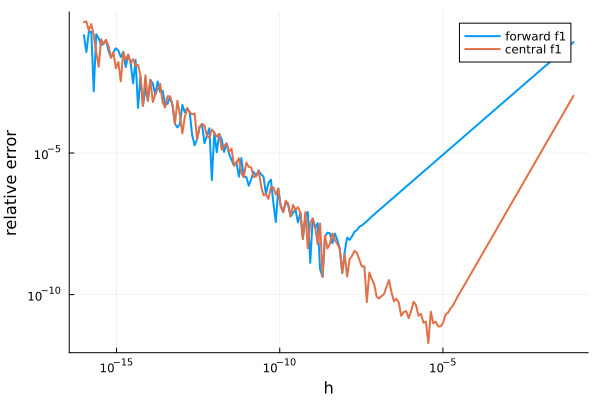

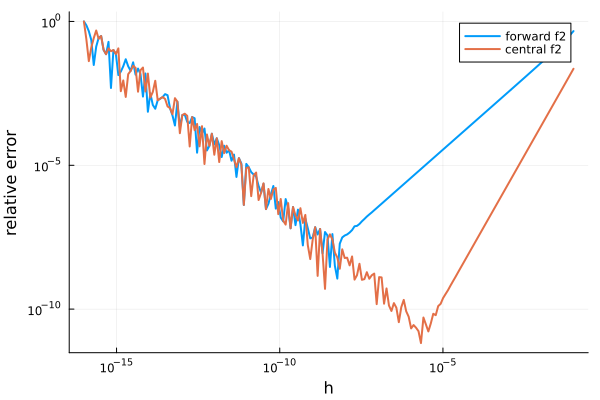

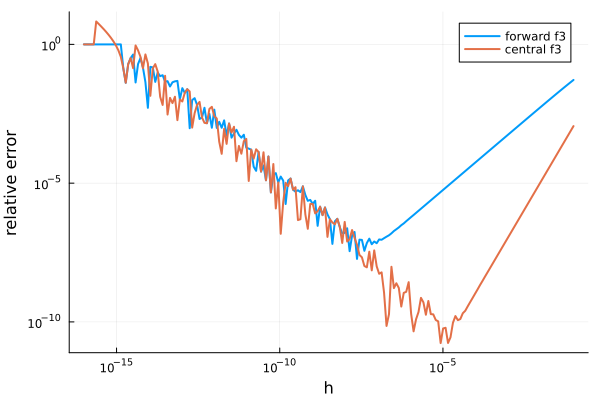

f1 at x=0.5: (hf = 2.049074689815846e-9, errf = 4.258226501431916e-10, hc = 3.5707859649004626e-6, errc = 1.944956551048867e-12)
f2 at x=1.0: (hf = 5.805225516094908e-9, errf = 1.1505655812625728e-9, hc = 2.121451784910632e-6, errc = 6.5995987468270825e-12)
f3 at x=2.0: (hf = 2.3272024789604073e-8, errf = 1.8606667861244323e-8, hc = 8.504489341802686e-6, errc = 1.7259023699061062e-11)


In [1]:
using LinearAlgebra
using Plots

# finite-difference schemes (the task's h-definition for central is used)
forward_diff(f, x, h) = (f(x + h) - f(x)) / h
central_diff(f, x, h) = (f(x + h/2) - f(x - h/2)) / h

# test functions and exact derivatives
f1(x) = sin(x^2)
f1p(x) = 2x * cos(x^2)

f2(x) = exp(3x^2)
f2p(x) = 6x * exp(3x^2)

f3(x) = atan(2x) / (1 + exp(-2x^2))          # g(x)*h(x)
f3p(x) = begin
    g  = atan(2x)
    gp = 2 / (1 + 4x^2)
    den  = 1 + exp(-2x^2)
    h  = 1/den
    hp = (4x*exp(-2x^2)) / den^2
    gp*h + g*hp
end

# points
x1, x2, x3 = 0.5, 1.0, 2.0

# grid of h (log-spaced)
hs = 10 .^ range(-16, -1; length=200)

function errors_vs_h(f, fp, x; hs=hs)
    exact = fp(x)
    ef = [abs(forward_diff(f,x,h) - exact)/abs(exact) for h in hs]
    ec = [abs(central_diff(f,x,h) - exact)/abs(exact) for h in hs]
    (; ef, ec, exact)
end

res1 = errors_vs_h(f1, f1p, x1)
res2 = errors_vs_h(f2, f2p, x2)
res3 = errors_vs_h(f3, f3p, x3)

# plot
plt1 = plot(hs, res1.ef; xscale=:log10, yscale=:log10, label="forward f1",
            xlabel="h", ylabel="relative error", lw=2)
plot!(hs, res1.ec; xscale=:log10, yscale=:log10, label="central f1", lw=2)

display(plt1)


plt2 = plot(hs, res2.ef; xscale=:log10, yscale=:log10, label="forward f2",
            xlabel="h", ylabel="relative error", lw=2)
plot!(hs, res2.ec; xscale=:log10, yscale=:log10, label="central f2", lw=2)

display(plt2)


plt3 = plot(hs, res3.ef; xscale=:log10, yscale=:log10, label="forward f3",
            xlabel="h", ylabel="relative error", lw=2)
plot!(hs, res3.ec; xscale=:log10, yscale=:log10, label="central f3", lw=2)

display(plt3)

# report best h (minimizer on the grid)
using Statistics
argmin_idx(v) = findmin(v)[2]
best = (name, ef, ec) -> (
    hf = hs[argmin_idx(ef)], errf = minimum(ef),
    hc = hs[argmin_idx(ec)], errc = minimum(ec)
)

println("f1 at x=0.5: ", best("f1", res1.ef, res1.ec))
println("f2 at x=1.0: ", best("f2", res2.ef, res2.ec))
println("f3 at x=2.0: ", best("f3", res3.ef, res3.ec))

## 13b:

The softmax function is defined as:
$$
S(z) = \frac{1}{\sum_{i=1}^K e^{z_i}}
\begin{bmatrix}
e^{z_1} \\ 
e^{z_2} \\ 
\vdots \\ 
e^{z_K}
\end{bmatrix}
$$

Its Jacobian $J$ is a $K \times K$ matrix.


1. **Forward difference to compute the Jacobian:**
   - Compute $ f(z) $ once for the unperturbed vector.
   - For each column, perturb one coordinate and compute $ f(z + h e_j) $.
   - **Total function evaluations: \( K + 1 \)**.

2. **Central difference to compute the Jacobian:**
   - For each column, compute $ f(z + \frac{h}{2} e_j) $ and $ f(z - \frac{h}{2} e_j) $
   - **Total function evaluations: \( 2K \)**.

## 13c:

Jacobian of softmax at $z$ with $s=S(z)$ is
$$
J = \mathrm{diag}(s) - s\,s^\top
$$
Use $z=[1^{1/3},2^{1/3},\dots,K^{1/3}]^\top$

In [2]:
# write method
# Jacobian 
softmax(z) = begin
    m = maximum(z)               # numerical stability
    w = exp.(z .- m)
    w ./ sum(w)
end

function jacobian_softmax_exact(z)
    s = softmax(z)
    Diagonal(s) - s*s'
end

# forward & central FD Jacobians (K+1 and 2K softmax calls, respectively)
function jacobian_forward(z, h)
    K = length(z)
    base = softmax(z)
    J = zeros(Float64, K, K)
    for j in 1:K
        zp = copy(z); zp[j] += h
        J[:, j] = (softmax(zp) - base) / h
    end
    J
end

function jacobian_central(z, h)
    K = length(z)
    J = zeros(Float64, K, K)
    hh = h/2
    for j in 1:K
        zp = copy(z); zm = copy(z)
        zp[j] += hh; zm[j] -= hh
        J[:, j] = (softmax(zp) - softmax(zm)) / h
    end
    J
end

jacobian_central (generic function with 1 method)

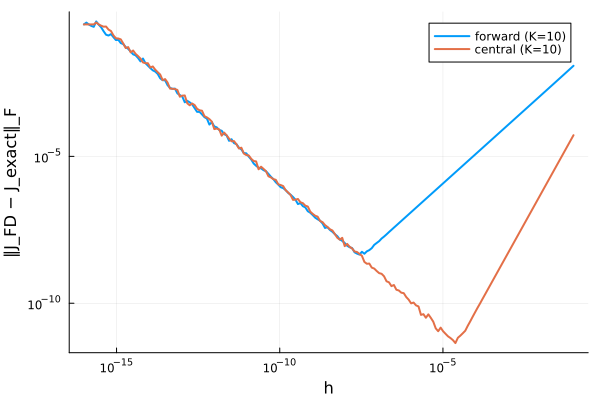

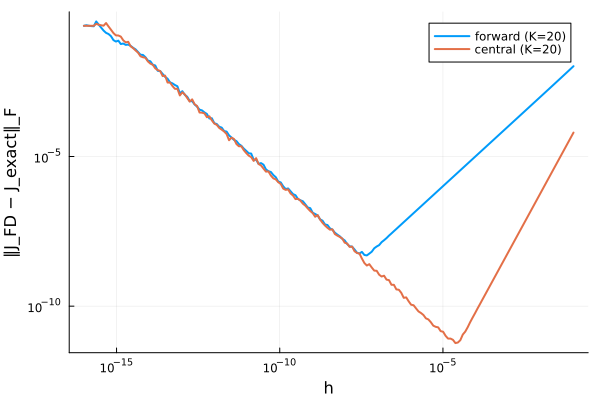

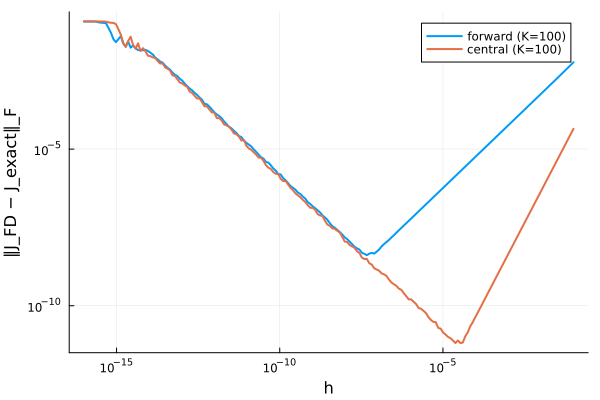

K=10: (2.7682866303920667e-8, 2.409403560239527e-5)
K=20: (4.659525668664677e-8, 2.409403560239527e-5)
K=100: (4.659525668664677e-8, 3.409285069746814e-5)


In [3]:
froerr(A,B) = sqrt(sum(abs2, A .- B))

# K = 10, 20, 100
Ks = [10, 20, 100]
hs = 10 .^ range(-16, -1; length=200)

errs_f = Dict{Int, Vector{Float64}}()
errs_c = Dict{Int, Vector{Float64}}()
best_h  = Dict{Int, Tuple{Float64, Float64}}()   # (best_h_forward, best_h_central)

for K in Ks
    z = [k^(1/3) for k in 1:K]
    Jex = jacobian_softmax_exact(z)
    ef = [froerr(jacobian_forward(z,h), Jex) for h in hs]
    ec = [froerr(jacobian_central(z,h), Jex) for h in hs]
    errs_f[K] = ef; errs_c[K] = ec
    hf = hs[argmin(ef)]; hc = hs[argmin(ec)]
    best_h[K] = (hf, hc)
end

# plots
for K in Ks
    p = plot(hs, errs_f[K]; xscale=:log10, yscale=:log10, lw=2,
             xlabel="h", ylabel="‖J_FD − J_exact‖_F", label="forward (K=$K)")
    plot!(hs, errs_c[K]; xscale=:log10, yscale=:log10, lw=2, label="central (K=$K)")
    display(p)
end

for K in Ks
    println("K=$(K): ", best_h[K])
end

* **Forward difference** (1st order):
  total error $\approx C\,h + \kappa\,\varepsilon/h$ ⇒
  $\boxed{h_\star \sim \sqrt{\varepsilon}}$

* **Central difference** (2nd order):
  total error $\approx C\,h^2 + \kappa\,\varepsilon/h$ ⇒
  $\boxed{h_\star \sim \varepsilon^{1/3}}$

---

*Use this area below as an experimental playground for the question. Feel free to leave some of the experimental code here with your submision. However, it will not be marked or reviewed. Make sure in your submission that if there is any experimental code here then running it does not interfere with running the actual solutions.*

---

# Solution to [Question 14](https://courses.smp.uq.edu.au/MATH2504/2024/assessment_html/bighw.html#q14)

In [4]:
using LinearAlgebra
using Random
using DataFrames
using Plots

function structured_P(L::Int; p::Float64=0.45, r::Float64=0.01)
    q = 1 - p - r
    P = diagm(0 => fill(r, L)) +
        diagm(-1 => fill(q, L-1)) +
        diagm( 1 => fill(p, L-1))
    P[1,1] = 1 - p
    P[L,L] = 1 - q
    return Matrix{Float64}(P)
end

structured_P (generic function with 1 method)

In [5]:
# Closed-form stationary distribution (column vector, sums to 1)
function structured_π(L::Int; p::Float64=0.45, r::Float64=0.01)
    q = 1 - p - r
    # birth-death explicit formula
    raw = [(p/q)^i for i in 1:L] .* ((q - p) / p) ./ (1 - (p/q)^L)
    v = collect(raw)
    v ./= sum(v)
    return v
end

# draw next state given current state i and transition matrix P
@inline function draw_next(i::Int, P::AbstractMatrix{<:Real})
    u = rand()
    s = 0.0
    @inbounds for j in 1:size(P,2)
        s += P[i,j]
        if u <= s
            return j
        end
    end
    return size(P,2)  # numeric safety
end

# Euclidean error
err(a::AbstractVector, b::AbstractVector) = norm(a .- b)

# Method 1: linear system πP = π, sum π = 1 
function stationary_linear(P::AbstractMatrix{<:Real})
    L = size(P,1)
    A = Matrix(I, L, L) .- transpose(P)   # (I - Pᵀ) π = 0
    A[end, :] .= 1.0                      # replace one eqn by sum-to-1
    b = zeros(L); b[end] = 1.0
    π = A \ b
    # ensure non-negativity up to rounding
    π = max.(π, 0)
    π ./= sum(π)
    return π
end

# Method 2: power (row of P^n) 
function stationary_power(P::AbstractMatrix{<:Real}, n::Int; i::Int=1)
    L = size(P,1)
    v = zeros(Float64, L)'; v[i] = 1.0     # e_iᵀ
    @inbounds for _ in 1:n
        v = v * P
    end
    π = vec(v)                             # as column vector
    π ./= sum(π)
    return π
end

# Method 3: eigenvector of Pᵀ for λ≈1 
function stationary_eig(P::AbstractMatrix{<:Real})
    E = eigen(transpose(P))                # eigenvectors in columns
    idx = argmin(abs.(E.values .- 1.0))
    v = real(E.vectors[:, idx])
    if sum(v) < 0
        v = -v
    end
    v = max.(v, 0)                         # clip tiny negative noise
    v ./= sum(v)
    return v
end

# Method 4: simulation (empirical frequencies)
function stationary_mc(P::AbstractMatrix{<:Real}, N::Int; burn::Int=10_000, x0::Int=1)
    L = size(P,1)
    counts = zeros(Float64, L)
    x = x0
    for _ in 1:burn
        x = draw_next(x, P)
    end
    for _ in 1:N
        x = draw_next(x, P)
        counts[x] += 1
    end
    π = counts ./ sum(counts)
    return π
end

# test
function run_data(; Ls = [2,3,4,5,10,20,30,40,50,100,200,300,400,500,1000],
                           p = 0.45, r = 0.01,
                           n_power_rule = L -> min(20_000, max(2_000, 150L)),
                           N_rule       = L -> min(2_000_000, max(100_000, 3000L)),
                           burn_rule    = L -> 10_000)

    rows = NamedTuple[]
    for L in Ls
        P       = structured_P(L; p=p, r=r)
        pi_star = structured_π(L; p=p, r=r)   

        n_power = n_power_rule(L)
        N_sim   = N_rule(L)
        burn    = burn_rule(L)

        t1 = @elapsed π1 = stationary_linear(P)
        t2 = @elapsed π2 = stationary_power(P, n_power; i=1)
        t3 = @elapsed π3 = stationary_eig(P)
        t4 = @elapsed π4 = stationary_mc(P, N_sim; burn=burn, x0=1)

        push!(rows, (L=L,
                     err_linear = err(π1, pi_star),
                     err_power  = err(π2, pi_star),
                     err_eig    = err(π3, pi_star),
                     err_mc     = err(π4, pi_star),
                     t_linear=t1, t_power=t2, t_eig=t3, t_mc=t4,
                     n_power=n_power, N_sim=N_sim))
    end
    DataFrame(rows)
end


df = run_data()
println(df)

15×11 DataFrame
 Row │ L      err_linear   err_power    err_eig      err_mc       t_linear   t_power    t_eig      t_mc       n_power  N_sim   
     │ Int64  Float64      Float64      Float64      Float64      Float64    Float64    Float64    Float64    Int64    Int64   
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     2  1.11022e-16  0.0          1.24127e-16  0.000713535  6.64e-5    0.0001035  0.698444   0.0007279     2000   100000
   2 │     3  7.85046e-17  7.85046e-17  4.80741e-16  5.68592e-5   8.2e-6     9.88e-5    1.52e-5    0.0007499     2000   100000
   3 │     4  1.30185e-16  7.85046e-17  1.49468e-16  0.00680006   1.6e-6     0.0001171  8.1e-6     0.0007815     2000   100000
   4 │     5  6.7987e-17   7.34344e-17  3.10317e-16  0.00512807   1.6e-6     0.0001288  8.5e-6     0.0008101     2000   100000
   5 │    10  7.10788e-16  2.23018e-16  2.42145e-15  0.00372715   3.1e-6     0.0002023  2.36

In [6]:
# make log become count
eps_err  = 1e-16    # minimum error
eps_time = 1e-12    # minimum time

for c in [:err_linear, :err_power, :err_eig, :err_mc]
    df[!, c] .= @. max(df[!, c], eps_err)
end

for c in [:t_linear, :t_power, :t_eig, :t_mc]
    df[!, c] .= @. max(df[!, c], eps_time)
end


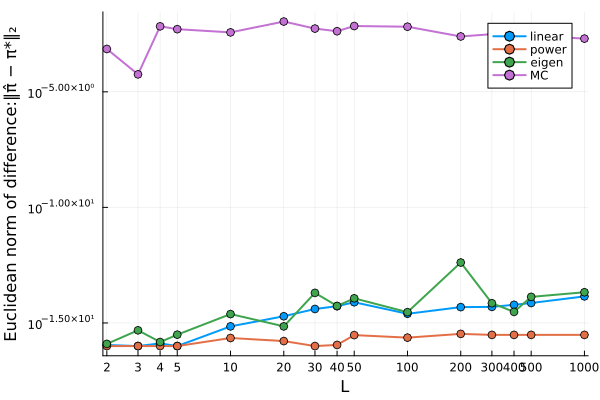

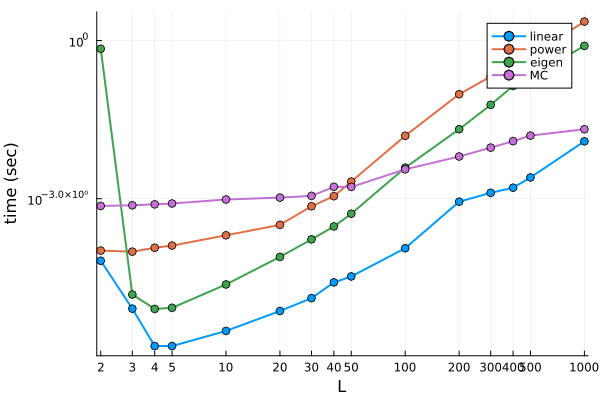

In [7]:
xt_vals = collect(df.L)
xt_labs = string.(xt_vals)
xlims_tuple = (minimum(xt_vals)*0.95, maximum(xt_vals)*1.05)

# difference
p1 = plot(df.L, df.err_linear;
    xscale=:log10, yscale=:log10,
    xticks=(xt_vals, xt_labs), xlims=xlims_tuple,
    yformatter=:scientific, m=:o, lw=2, label="linear",
    xlabel="L", ylabel="Euclidean norm of difference:‖π̂ − π*‖₂")
plot!(df.L, df.err_power;  xscale=:log10, yscale=:log10, xticks=(xt_vals, xt_labs), xlims=xlims_tuple, yformatter=:scientific, m=:o, lw=2, label="power")
plot!(df.L, df.err_eig;    xscale=:log10, yscale=:log10, xticks=(xt_vals, xt_labs), xlims=xlims_tuple, yformatter=:scientific, m=:o, lw=2, label="eigen")
plot!(df.L, df.err_mc;     xscale=:log10, yscale=:log10, xticks=(xt_vals, xt_labs), xlims=xlims_tuple, yformatter=:scientific, m=:o, lw=2, label="MC")
display(p1)

# time
p2 = plot(df.L, df.t_linear;
    xscale=:log10, yscale=:log10,
    xticks=(xt_vals, xt_labs), xlims=xlims_tuple,
    yformatter=:scientific, m=:o, lw=2, label="linear",
    xlabel="L", ylabel="time (sec)")
plot!(df.L, df.t_power;  xscale=:log10, yscale=:log10, xticks=(xt_vals, xt_labs), xlims=xlims_tuple, yformatter=:scientific, m=:o, lw=2, label="power")
plot!(df.L, df.t_eig;    xscale=:log10, yscale=:log10, xticks=(xt_vals, xt_labs), xlims=xlims_tuple, yformatter=:scientific, m=:o, lw=2, label="eigen")
plot!(df.L, df.t_mc;     xscale=:log10, yscale=:log10, xticks=(xt_vals, xt_labs), xlims=xlims_tuple, yformatter=:scientific, m=:o, lw=2, label="MC")
display(p2)


---

*Use this area below as an experimental playground for the question. Feel free to leave some of the experimental code here with your submision. However, it will not be marked or reviewed. Make sure in your submission that if there is any experimental code here then running it does not interfere with running the actual solutions.*

---

# Solution to [Question 15](https://courses.smp.uq.edu.au/MATH2504/2024/assessment_html/bighw.html#q15)

## 15a:

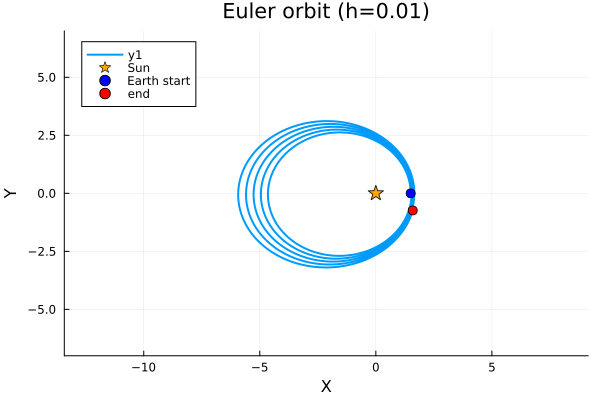

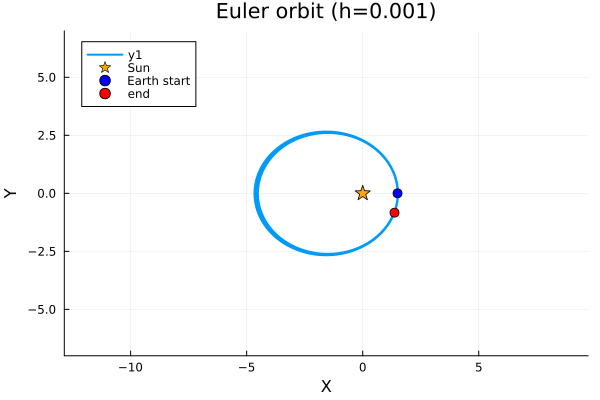

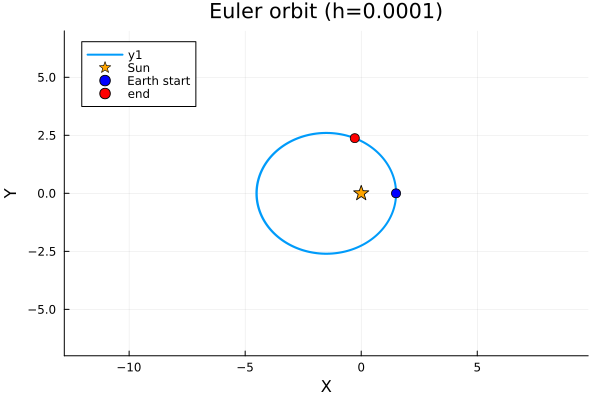

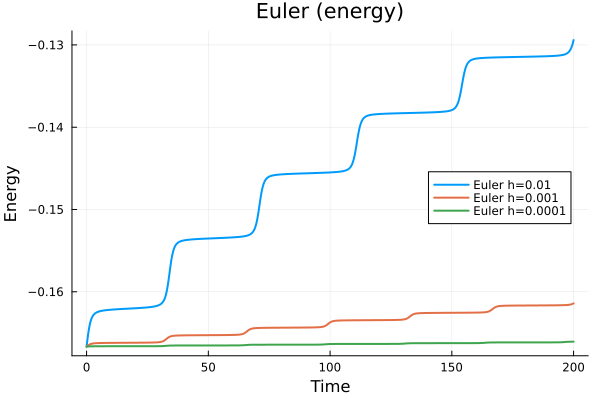

In [8]:
using LinearAlgebra
using Plots, Measures

const MG = 1.0                     # unit：G*M=1
# vector u = [vx, vy, x, y]
function df_dt_one_body(u::Vector{Float64}, t::Float64)
    vx, vy, x, y = u[1], u[2], u[3], u[4]
    r2 = x*x + y*y
    r  = sqrt(r2)
    r3 = r2 * r
    ax = -MG * x / r3
    ay = -MG * y / r3
    return [ax, ay, vx, vy]        # u' = [ax, ay, vx, vy]
end

# euler
function euler_fast(f, u0::Vector{Float64}; h::Float64, tmax::Float64, save_every::Int=1)
    steps = Int(round(tmax / h))
    saved = steps ÷ save_every + 1
    T = Vector{Float64}(undef, saved + 1)        
    U = Matrix{Float64}(undef, 4, saved + 1)     # list: [vx,vy,x,y]

    u = copy(u0)
    T[1] = 0.0
    U[:,1] .= u
    s = 1
    t = 0.0

    @inbounds for k in 1:steps
        u .+= h .* f(u, t)                       # Euler
        t += h
        if k % save_every == 0
            s += 1
            T[s] = t
            U[:,s] .= u
        end
    end
    if T[s] != t
        s += 1; T[s] = t; U[:,s] .= u
    end
    return T[1:s], U[:,1:s]
end

# plot
plot_orbit_mat(T, U; title="") = begin
    xs = @view U[3, :]; ys = @view U[4, :]
    p = plot(xs, ys; aspect_ratio=1, lw=2, title=title,
             xlabel="X", ylabel="Y", legend=:topleft, ylim=(-7,7))
    scatter!(p, [0.0], [0.0]; ms=8, label="Sun", color=:orange, shape=:star5)
    scatter!(p, [xs[1]], [ys[1]]; ms=5, label="Earth start", color=:blue, shape=:circle)
    scatter!(p, [xs[end]], [ys[end]]; ms=5, label="end", color=:red,  shape=:circle)
    p
end

energy_series_mat(U) = begin
    n = size(U, 2)
    E = Vector{Float64}(undef, n)
    @inbounds for i in 1:n
        vx, vy, x, y = U[1,i], U[2,i], U[3,i], U[4,i]
        E[i] = 0.5*(vx^2 + vy^2) - MG/sqrt(x^2 + y^2)
    end
    E
end

plot_energy_compare_mats(Ts, Us, labels; title="") = begin
    p = plot(title=title*" (energy)", xlabel="Time", ylabel="Energy", legend=:right)
    for i in eachindex(Ts)
        plot!(p, Ts[i], energy_series_mat(Us[i]); lw=2, label=labels[i])
    end
    p
end

# 15a
hlist = [0.01, 0.001, 0.0001]
tmax  = 200.0
u0    = [0.0, 1.0, 1.5, 0.0]                   # speed (0,1)，position (1.5,0)

# change step size
save_every_map = Dict(0.01=>1, 0.001=>10, 0.0001=>100)

Ts_E = Vector{Vector{Float64}}()
Us_E = Vector{Matrix{Float64}}()
labels = ["Euler h=$(h)" for h in hlist]

for h in hlist
    T, U = euler_fast(df_dt_one_body, u0; h=h, tmax=tmax, save_every=save_every_map[h])
    push!(Ts_E, T); push!(Us_E, U)
    display(plot_orbit_mat(T, U; title="Euler orbit (h=$(h))"))  
end

# energy
display(plot_energy_compare_mats(Ts_E, Us_E, labels; title="Euler"))


## 15b:

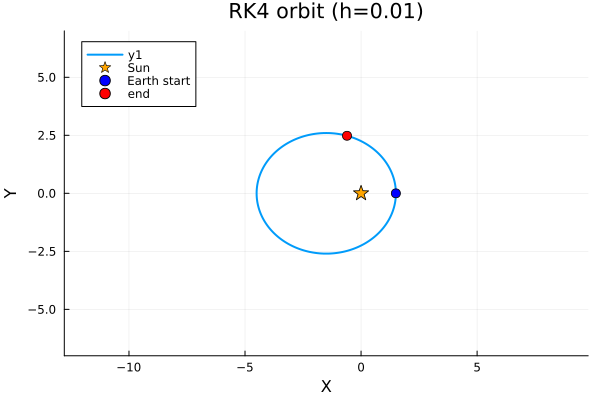

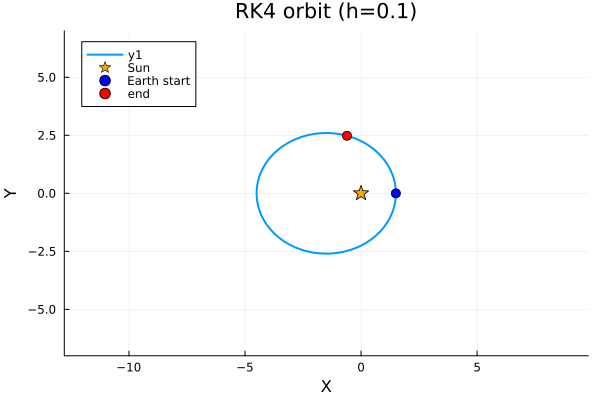

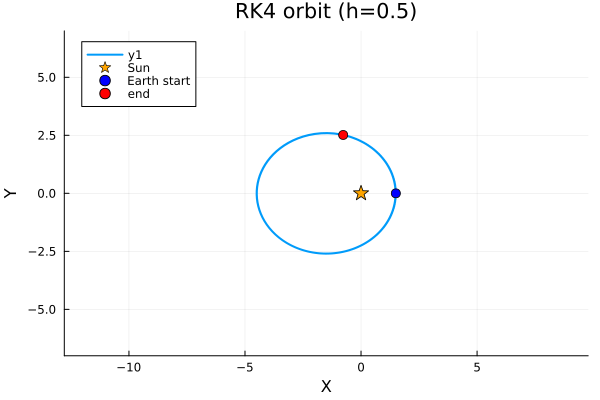

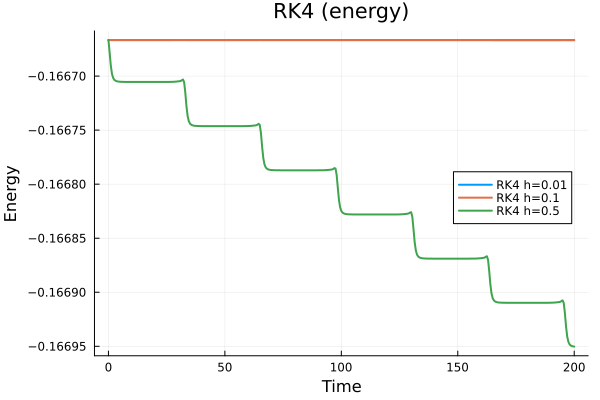

In [9]:
# RK4
function rk4_fast(f, u0::Vector{Float64}; h::Float64, tmax::Float64, save_every::Int=1)
    steps = Int(round(tmax / h))
    saved = steps ÷ save_every + 1
    T = Vector{Float64}(undef, saved + 1)
    U = Matrix{Float64}(undef, 4, saved + 1)   # list: [vx,vy,x,y]

    u = copy(u0)
    T[1] = 0.0
    U[:,1] .= u
    s = 1
    t = 0.0

    @inbounds for k in 1:steps
        k1 = f(u, t)
        k2 = f(u .+ 0.5h .* k1, t + 0.5h)
        k3 = f(u .+ 0.5h .* k2, t + 0.5h)
        k4 = f(u .+ h .* k3,     t + h)
        u  .+= (h/6) .* (k1 .+ 2k2 .+ 2k3 .+ k4)
        t  += h
        if k % save_every == 0
            s += 1
            T[s] = t
            U[:,s] .= u
        end
    end
    if T[s] != t
        s += 1; T[s] = t; U[:,s] .= u
    end
    return T[1:s], U[:,1:s]
end

hlist_RK4 = [0.01, 0.1, 0.5]
tmax = 200.0
u0   = [0.0, 1.0, 1.5, 0.0]

# change step size
save_every_map_RK4 = Dict(0.01=>1, 0.1=>1, 0.5=>1)

Ts_R = Vector{Vector{Float64}}()
Us_R = Vector{Matrix{Float64}}()
labels_R = ["RK4 h=$(h)" for h in hlist_RK4]

for h in hlist_RK4
    T,U = rk4_fast(df_dt_one_body, u0; h=h, tmax=tmax, save_every=save_every_map_RK4[h])
    push!(Ts_R, T); push!(Us_R, U)
    display(plot_orbit_mat(T, U; title="RK4 orbit (h=$(h))"))  # 三张轨道图
end

# energy
display(plot_energy_compare_mats(Ts_R, Us_R, labels_R; title="RK4"))


## 15c:

15c summary (method, h, saved_points, time[s], max_energy_drift):
 Euler  h= 0.0100   pts=  20001   time=  0.001   drift=3.725794e-02
 Euler  h= 0.0010   pts=  20001   time=  0.008   drift=5.259854e-03
 Euler  h= 0.0001   pts=  20001   time=  0.286   drift=5.976428e-04
   RK4  h= 0.0100   pts=  20001   time=  0.018   drift=3.449130e-12
   RK4  h= 0.1000   pts=   2001   time=  0.001   drift=1.125848e-07
   RK4  h= 0.5000   pts=    401   time=  0.000   drift=2.836301e-04


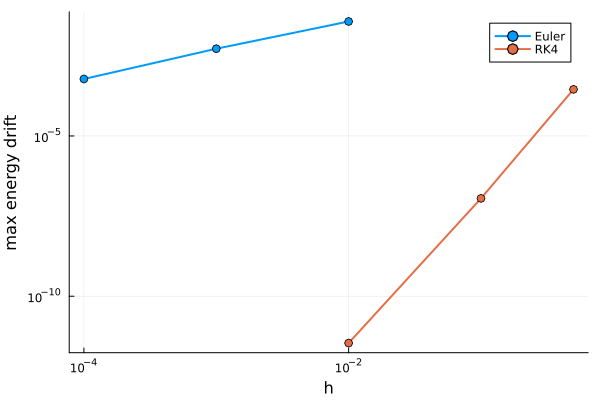


Conclusion: Overall, RK4 can maintain significantly smaller energy drift at larger step sizes; Euler requires a very small h to be barely usable.


In [10]:
using Printf

# max drift
max_energy_drift_mat(U) = begin
    E = energy_series_mat(U)
    maximum(abs.(E .- E[1]))
end

# run
function run_with_stats_fast(method::String, h; tmax=200.0, save_every=1)
    u0 = [0.0, 1.0, 1.5, 0.0]
    T = Float64[]; U = Matrix{Float64}(undef, 4, 0)
    runtime = @elapsed begin
        if startswith(method, "Euler")
            T,U = euler_fast(df_dt_one_body, u0; h=h, tmax=tmax, save_every=save_every)
        else
            T,U = rk4_fast(df_dt_one_body, u0; h=h, tmax=tmax, save_every=save_every)
        end
    end
    drift = max_energy_drift_mat(U)
    (method=method, h=h, points=size(U,2), time=runtime, drift=drift, T=T, U=U)
end

# Euler three + RK4 three
hs_E = [0.01, 0.001, 0.0001]
hs_R = [0.01, 0.1,   0.5]

# change step size
save_map_E = Dict(0.01=>1, 0.001=>10, 0.0001=>100)
save_map_R = Dict(0.01=>1, 0.1=>1,   0.5=>1)

stats = NamedTuple[]
for h in hs_E
    push!(stats, run_with_stats_fast("Euler", h; save_every=save_map_E[h]))
end
for h in hs_R
    push!(stats, run_with_stats_fast("RK4",   h; save_every=save_map_R[h]))
end

println("15c summary (method, h, saved_points, time[s], max_energy_drift):")
for s in stats
    @printf("%6s  h=%7.4f   pts=%7d   time=%7.3f   drift=%10.6e\n",
            s.method, s.h, s.points, s.time, s.drift)
end

# drift vs h
hs_E_plot = [s.h for s in stats if s.method=="Euler"]
dr_E_plot = [s.drift for s in stats if s.method=="Euler"]
hs_R_plot = [s.h for s in stats if s.method=="RK4"]
dr_R_plot = [s.drift for s in stats if s.method=="RK4"]

# prevent from 0
eps = 1e-16
dr_E_plot .= max.(dr_E_plot, eps)
dr_R_plot .= max.(dr_R_plot, eps)

p = plot(hs_E_plot, dr_E_plot; m=:o, lw=2, xscale=:log10, yscale=:log10,
         xlabel="h", ylabel="max energy drift", label="Euler")
plot!(p, hs_R_plot, dr_R_plot; m=:o, lw=2, xscale=:log10, yscale=:log10, label="RK4")
display(p)

println("\nConclusion: Overall, RK4 can maintain significantly smaller energy drift at larger step sizes; Euler requires a very small h to be barely usable.")

## 15d:

In [11]:
if !@isdefined(stats)
    include_string(Main, """
    """)
end

# best and worst
imax = argmax([s.drift for s in stats])
imin = argmin([s.drift for s in stats])
worst = stats[imax]
best  = stats[imin]

# orbit stat
Tb, Ub = best.T,  best.U
Tw, Uw = worst.T, worst.U
nb, nw = size(Ub,2), size(Uw,2)
N      = min(nb, nw)

# fps set
frame_stride = max(1, N ÷ 600)  
idxs = 1:frame_stride:N

xs_b = @view Ub[3, :]
ys_b = @view Ub[4, :]
xs_w = @view Uw[3, :]
ys_w = @view Uw[4, :]

anim = @animate for k in idxs
    p = plot(; aspect_ratio=1, xlim=(-7,7), ylim=(-7,7),
             title = @sprintf("Best vs Worst  (t=%.2f)  |  Best: %s h=%.4f   Worst: %s h=%.4f",
                              Tb[k], best.method, best.h, worst.method, worst.h),
             xlabel="X", ylabel="Y", legend=:topright)
    scatter!(p, [0.0], [0.0]; ms=8, label="Sun", color=:orange, shape=:star5)
    plot!(p, xs_b[1:k], ys_b[1:k]; lw=3, color=:green,  label="Best")
    plot!(p, xs_w[1:k], ys_w[1:k]; lw=3, color=:red,    label="Worst")
end

gif(anim, "best_vs_worst.gif"; fps=30)
println("best_vs_worst.gif get")


best_vs_worst.gif get


[ Info: Saved animation to C:\Users\32466\Julia7504\best_vs_worst.gif


![动态图](best_vs_worst.gif)

---

*Use this area below as an experimental playground for the question. Feel free to leave some of the experimental code here with your submision. However, it will not be marked or reviewed. Make sure in your submission that if there is any experimental code here then running it does not interfere with running the actual solutions.*

---

# Solution to [Question 16](https://courses.smp.uq.edu.au/MATH2504/2024/assessment_html/bighw.html#q16)

# 16 :

In [12]:
using LinearAlgebra
using Plots, Measures
const MG = 1.0

accel(x::AbstractVector) = begin
    r2 = x[1]^2 + x[2]^2
    r  = sqrt(r2)
    r3 = r2 * r
    @assert r3 > 0 "r=0 encountered"
    @. -MG * x / r3
end

kinetic(v)   = 0.5 * (v[1]^2 + v[2]^2)
potential(x) = -MG / sqrt(x[1]^2 + x[2]^2)
energy(x,v)  = kinetic(v) + potential(x)

function plot_orbit(xhist; title="")
    xs = first.(xhist); ys = last.(xhist)
    p = plot(xs, ys; aspect_ratio=1, lw=2, title=title,
             xlabel="X", ylabel="Y", legend=:topleft, ylim=(-7,7))
    scatter!(p, [0.0], [0.0]; ms=8, label="Sun", color=:orange, shape=:star5)
    scatter!(p, [xs[1]], [ys[1]]; ms=5, label="start", color=:blue, shape=:circle)
    scatter!(p, [xs[end]], [ys[end]]; ms=5, label="end",   color=:red,  shape=:circle)
    p
end

x0 = [1.5, 0.0]
v0 = [0.0, 1.0]
tmax = 200.0


200.0

## 16a:

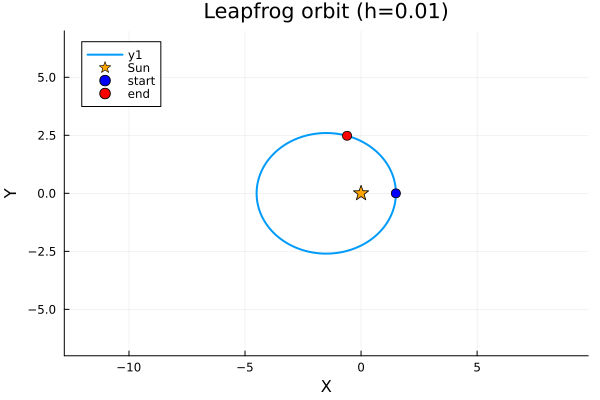

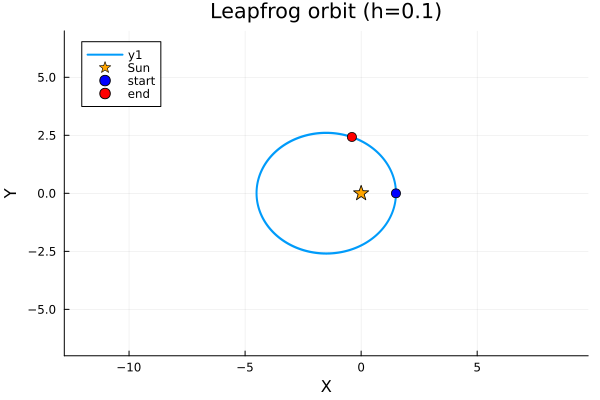

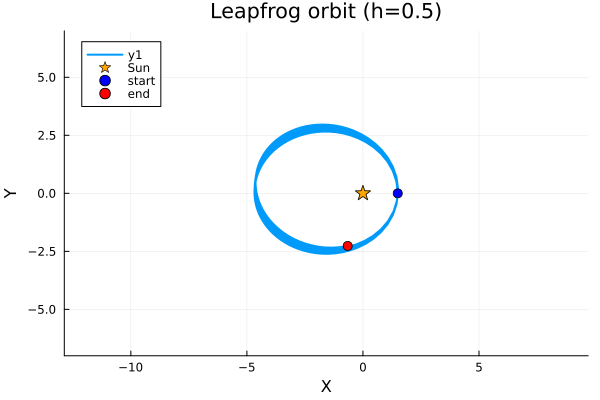

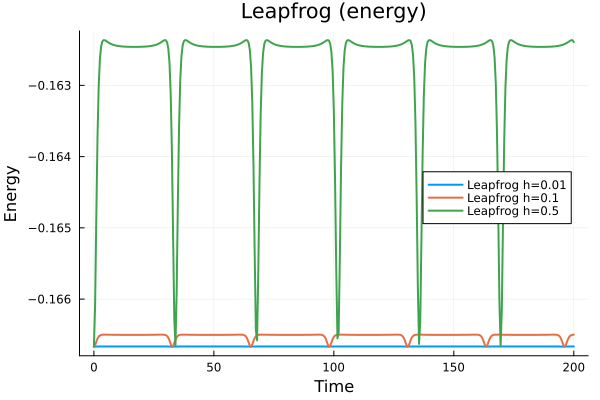

In [13]:
# second order Leapfrog
function leapfrog(accel, x0::Vector{Float64}, v0::Vector{Float64};
                  h::Float64, tmax::Float64)
    t = collect(0:h:tmax);  N = length(t)
    xhist = Vector{Vector{Float64}}(undef, N)
    vhist = Vector{Vector{Float64}}(undef, N)

    x = copy(x0); v = copy(v0)
    xhist[1] = copy(x); vhist[1] = copy(v)

    # half kick
    vhalf = v .+ (h/2) .* accel(x)

    for k in 1:N-1
        # drift
        x = x .+ h .* vhalf
        # kick
        vhalf = vhalf .+ h .* accel(x)
        v = vhalf .- (h/2) .* accel(x)

        xhist[k+1] = copy(x)
        vhist[k+1] = copy(v)
    end
    return t, xhist, vhist
end

# 3 step size
hs = [0.01, 0.1, 0.5]
ts = Vector{Vector{Float64}}()
Xs = Vector{Vector{Vector{Float64}}}()
Vs = Vector{Vector{Vector{Float64}}}()
labs = ["Leapfrog h=$(h)" for h in hs]

for h in hs
    t, xhist, vhist = leapfrog(accel, x0, v0; h=h, tmax=tmax)
    push!(ts, t); push!(Xs, xhist); push!(Vs, vhist)
end

# orbit
display(plot_orbit(Xs[1]; title="Leapfrog orbit (h=0.01)"))
display(plot_orbit(Xs[2]; title="Leapfrog orbit (h=0.1)"))
display(plot_orbit(Xs[3]; title="Leapfrog orbit (h=0.5)"))

# energy compare
pE = plot(xlabel="Time", ylabel="Energy", title="Leapfrog (energy)", legend=:right)
for i in 1:length(hs)
    Es = [energy(Xs[i][k], Vs[i][k]) for k in eachindex(ts[i])]
    plot!(pE, ts[i], Es; lw=2, label=labs[i])
end
display(pE)


## 16b:

## Leapfrog (kick–drift–kick)

* **$f$ evaluations:** **2 per step** (at $x(t)$ and $x(t+h)$).
* **Vector ops (2D):** about **3 AXPY** (updates of `v_half`, `x`, and `v`).
* **Property:** **Symplectic** (very small long-term energy drift; high trajectory quality).

## Euler (explicit, written as first-order system)

* **$f$ evaluations:** **1 per step**.
* **Vector ops:** **1 AXPY** (`u ← u + h f(u)`).
* **Property:** **Non-symplectic**; over long times the energy typically **diverges** or shows step-like bias.

## RK4 (classic 4th order)

* **$f$ evaluations:** **4 per step** ($k_1, k_2, k_3, k_4$).
* **Vector ops:** about **6–7 AXPY** (to form the Runge–Kutta combination).
* **Property:** **Non-symplectic**; very accurate in the short/mid term, but energy still **drifts** over long integrations.


## 16c:

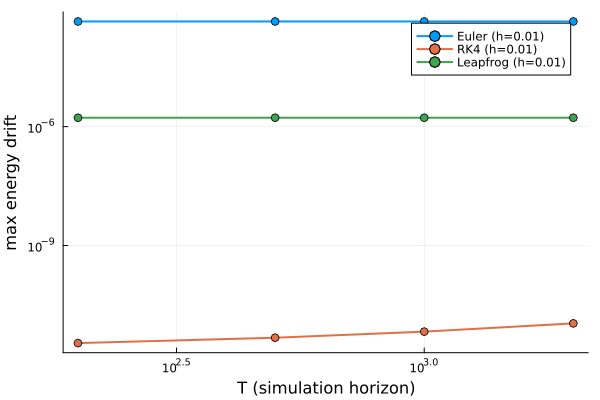

Conclusion: As T increases, Euler drift is the fastest; RK4 is second; Leapfrog is the most stable (increases the slowest).


In [14]:
h_euler = 0.01
h_rk4   = 0.01
h_lf    = 0.01
T_list  = [200.0, 500.0, 1000.0, 2000.0]

function euler_1st(f_accel, x0, v0; h, tmax)
    t = collect(0:h:tmax); N = length(t)
    xhist = Vector{Vector{Float64}}(undef, N)
    vhist = Vector{Vector{Float64}}(undef, N)
    x = copy(x0); v = copy(v0)
    xhist[1]=copy(x); vhist[1]=copy(v)
    for k in 1:N-1
        a = f_accel(x)
        v .+= h .* a
        x .+= h .* v
        xhist[k+1]=copy(x); vhist[k+1]=copy(v)
    end
    return t,xhist,vhist
end

function rk4_1st(f_accel, x0, v0; h, tmax)
    function f(u)
        x = @view u[1:2]; v=@view u[3:4]
        [v; accel(x)]
    end
    t = collect(0:h:tmax); N = length(t)
    X = Vector{Vector{Float64}}(undef, N)
    V = Vector{Vector{Float64}}(undef, N)
    u = [x0; v0]
    X[1]=copy(x0); V[1]=copy(v0)
    for k in 1:N-1
        k1 = f(u)
        k2 = f(u .+ 0.5h .* k1)
        k3 = f(u .+ 0.5h .* k2)
        k4 = f(u .+ h     .* k3)
        u  .= u .+ (h/6) .* (k1 .+ 2k2 .+ 2k3 .+ k4)
        X[k+1] = u[1:2]; V[k+1] = u[3:4]
    end
    return t,X,V
end

function max_energy_drift(xhist, vhist)
    Es = [energy(xhist[k], vhist[k]) for k in eachindex(xhist)]
    maximum(abs.(Es .- Es[1]))
end

drift_E = Float64[]; drift_R = Float64[]; drift_L = Float64[]

for T in T_list
    t,x,v = euler_1st(accel, x0, v0; h=h_euler, tmax=T)
    push!(drift_E, max_energy_drift(x,v))

    t,x,v = rk4_1st(accel, x0, v0; h=h_rk4, tmax=T)
    push!(drift_R, max_energy_drift(x,v))

    t,x,v = leapfrog(accel, x0, v0; h=h_lf, tmax=T)
    push!(drift_L, max_energy_drift(x,v))
end

p = plot(T_list, drift_E; xscale=:log10, yscale=:log10, m=:o, lw=2,
         xlabel="T (simulation horizon)", ylabel="max energy drift",
         label="Euler (h=$(h_euler))")
plot!(p, T_list, drift_R; m=:o, lw=2, label="RK4 (h=$(h_rk4))")
plot!(p, T_list, drift_L; m=:o, lw=2, label="Leapfrog (h=$(h_lf))")
display(p)

println("Conclusion: As T increases, Euler drift is the fastest; RK4 is second; Leapfrog is the most stable (increases the slowest).")

## 16d:

In [15]:
import Pkg; Pkg.add("DifferentialEquations")

   Resolving package versions...
  No Changes to `C:\Users\32466\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\32466\.julia\environments\v1.11\Manifest.toml`


In [16]:
using DifferentialEquations   # Tsit5, VerletLeapfrog

kinetic(v)   = 0.5*(v[1]^2 + v[2]^2)
potential(x) = -MG / sqrt(x[1]^2 + x[2]^2)
energy(x,v)  = kinetic(v) + potential(x)

# own leapfrog
function leapfrog_own(accel, x0::Vector{Float64}, v0::Vector{Float64};
                      dt::Float64, tmax::Float64)
    N = floor(Int, tmax/dt)
    T = collect(0:dt:dt*N)
    X = zeros(2, N+1); V = zeros(2, N+1)

    x = copy(x0); v = copy(v0)
    X[:,1] .= x;   V[:,1] .= v

    for k in 1:N
        a1 = accel(x)
        vhalf = v .+ 0.5*dt .* a1         # kick(1/2)
        x     = x .+ dt .* vhalf          # drift
        a2 = accel(x)
        v     = vhalf .+ 0.5*dt .* a2     # kick(1/2)

        X[:,k+1] .= x
        V[:,k+1] .= v
    end
    return T, X, V
end

# initial data 
x0   = [1.5, 0.0]
v0   = [0.0, 1.0]
tmax = 200.0
dt   = 0.01                   # compare on the same grid

# Non-symplectic: Tsit5 on first-order system
function f1!(du, u, p, t)
    x, y, vx, vy = u
    r2 = x^2 + y^2
    r  = sqrt(r2); r3 = r2*r
    du[1] = vx
    du[2] = vy
    du[3] = -MG * x / r3
    du[4] = -MG * y / r3
end

u0_1st = [x0[1], x0[2], v0[1], v0[2]]
prob1  = ODEProblem(f1!, u0_1st, (0.0, tmax))
t_tsit = @elapsed sol1 = solve(prob1, Tsit5(); saveat=dt)  # fixed save grid
E_tsit = [energy(@view(u[1:2]), @view(u[3:4])) for u in sol1.u]
X_tsit = reduce(hcat, [u[1:2] for u in sol1.u])            # 2×M positions

# Symplectic: VerletLeapfrog on second-order system 
function a_second!(ddx, x, p, t)
    ddx .= accel(x)
end
prob2 = SecondOrderODEProblem(a_second!, x0, v0, (0.0, tmax))
t_vlf = @elapsed sol2 = solve(prob2, VerletLeapfrog(); dt=dt, saveat=dt)
# sol2.u[i] is ArrayPartition(x, v)
E_vlf = [energy(u.x[1], u.x[2]) for u in sol2.u]
X_vlf = reduce(hcat, [u.x[1] for u in sol2.u])             # 2×M positions

# Our own leapfrog
t_own = @elapsed T_own, X_own, V_own = leapfrog_own(accel, x0, v0; dt=dt, tmax=tmax)
E_own = [energy(X_own[:,k], V_own[:,k]) for k in 1:length(T_own)]

# energy drift & timings
drift(E) = maximum(abs.(E .- E[1]))
println("Max energy drift & runtime (dt=$dt, tmax=$tmax):")
println("  Tsit5           : drift=", drift(E_tsit), "   time=", t_tsit, " s")
println("  VerletLeapfrog  : drift=", drift(E_vlf),  "   time=", t_vlf,  " s")
println("  Own  Leapfrog   : drift=", drift(E_own),  "   time=", t_own,  " s")

Max energy drift & runtime (dt=0.01, tmax=200.0):
  Tsit5           : drift=0.009664532600619613   time=1.3551148 s
  VerletLeapfrog  : drift=1017.7402204630263   time=2.1707104 s
  Own  Leapfrog   : drift=1.6775797679058346e-6   time=0.402651 s


Tsit5 having ~10⁻² drift over 200 time units is expected 

Verlet looks “bad” if the second-order function is mis-specified or energy readout is wrong

Own leapfrog result (drift ~1.7×10⁻⁶) is the correct symplectic behavior

---

*Use this area below as an experimental playground for the question. Feel free to leave some of the experimental code here with your submision. However, it will not be marked or reviewed. Make sure in your submission that if there is any experimental code here then running it does not interfere with running the actual solutions.*

---

# Solution to [Question 17](https://courses.smp.uq.edu.au/MATH2504/2024/assessment_html/bighw.html#q17)

Dr. Foeglein’s career began in the abstract realm of pure mathematics—her doctoral research focused on non-Euclidean partial differential equations. Yet her childhood exposure to the Commodore 64 and SimCity ignited a passion for transforming mathematics into tangible solutions. Disillusioned by academia’s detachment, she pivoted to industry. There, she merged mathematical rigor with software engineering and statistics to tackle real-world challenges in logistics systems.

Today, she meticulously optimizes supply chains for the Dalrymple Bay Coal Terminal in Queensland. Her work involves building simulation models to resolve bottlenecks in train/ship coordination, forecasting demand, and advising stakeholders. This requires striking a balance between technical precision and diplomacy to reconcile competing business interests. She acknowledges moral conflicts in supporting coal logistics but values preventing taxpayer losses through efficiency gains.

Dr. Foeglein highlighted tools like AnyLogic—a hybrid simulation platform previously unfamiliar to me. It blends agent-based, discrete-event, and system dynamics modeling to replicate real-world chaos, such as simulating equipment failures and market volatility. She integrates this platform with Python/R for statistical analysis of simulation outputs, uses stochastic methods to quantify randomness (e.g., weather delays at ports), and employs optimization algorithms such as tabu search. For instance, she resolved gate-assignment chaos at Sydney Airport, where human decision rules fell short. I was particularly intrigued by Anna’s "mathematization of problems" approach: distilling vague business challenges into computable mathematical propositions. This abstraction doesn’t seek full realism but captures key decision variables with minimal mathematical structure.

Her insights taught me that simulation results must fuse with human intuition. As she noted: "Models only tell you what happened; explaining why requires conversations with on-site personnel." Most thought-provoking was her candor about technical limitations: even precise models demand compromise. For example, she used 3D animations to win decision-makers’ trust before implementing code-based optimizations. This technical pragmatism will profoundly shape my future problem-solving approach.